# Single-cell RNA-seq analysis workflow for 1.3 M cells using Scanpy on CPU

Copyright (c) 2020, NVIDIA CORPORATION.
Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License. You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

## Import requirements

In [1]:
import time

import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.cluster import KMeans

import os, wget

import utils

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')

## Input data

In [2]:
# Add path to input file here.
input_file = "../data/1M_brain_cells_10X.sparse.h5ad"

if not os.path.exists(input_file):
    print('Downloading import file...')
    os.makedirs('../data', exist_ok=True)
    wget.download('https://rapids-single-cell-examples.s3.us-east-2.amazonaws.com/1M_brain_cells_10X.sparse.h5ad',
              input_file)

## Set parameters

In [3]:
# marker genes
MITO_GENE_PREFIX = "mt-" # Prefix for mitochondrial genes to regress out
markers = ["Stmn2", "Hes1", "Olig1"] # Marker genes for visualization

# filtering cells
min_genes_per_cell = 200 # Filter out cells with fewer genes than this expressed 
max_genes_per_cell = 6000 # Filter out cells with more genes than this expressed 

# filtering genes
min_cells_per_gene = 1 # Filter out genes expressed in fewer cells than this
n_top_genes = 4000 # Number of highly variable genes to retain

# PCA
n_components = 50 # Number of principal components to compute

# t-SNE
tsne_n_pcs = 20 # Number of principal components to use for t-SNE

# k-means
k = 35 # Number of clusters for k-means

# KNN
n_neighbors = 15 # Number of nearest neighbors for KNN graph
knn_n_pcs = 50 # Number of principal components to use for finding nearest neighbors

# UMAP
umap_min_dist = 0.3 
umap_spread = 1.0

# Gene ranking
ranking_n_top_genes = 50 # Number of differential genes to compute for each cluster

# Number of parallel jobs
sc._settings.ScanpyConfig.n_jobs = 40

In [4]:
start = time.time()

## Load and Prepare Data

In [5]:
%%time
adata = sc.read(input_file)
adata.var_names_make_unique()
adata.shape

CPU times: user 44.1 s, sys: 5.96 s, total: 50.1 s
Wall time: 50.1 s


(1306127, 27998)

In [6]:
# To reduce the number of cells: 
USE_FIRST_N_CELLS = 1300000
adata = adata[0:USE_FIRST_N_CELLS]
adata.shape

(1300000, 27998)

## Preprocessing

In [7]:
preprocess_start = time.time()

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.

In [8]:
%%time
sc.pp.filter_cells(adata, min_genes=min_genes_per_cell)
sc.pp.filter_cells(adata, max_genes=max_genes_per_cell)

CPU times: user 2min 16s, sys: 32.7 s, total: 2min 48s
Wall time: 2min 48s


Some genes will now have zero expression in all cells. We filter out such genes.

In [9]:
%%time
sc.pp.filter_genes(adata, min_cells=min_cells_per_gene)

CPU times: user 28.2 s, sys: 7.63 s, total: 35.8 s
Wall time: 35.8 s


In [10]:
adata.shape

(1285302, 23992)

### Normalize

In [11]:
%%time
sc.pp.normalize_total(adata, target_sum=1e4)

CPU times: user 6.66 s, sys: 1.05 s, total: 7.71 s
Wall time: 7.7 s


In [12]:
%%time
sc.pp.log1p(adata)

CPU times: user 19.6 s, sys: 1.33 ms, total: 19.6 s
Wall time: 19.6 s


### Select Most Variable Genes

In [13]:
%%time

# Select highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, flavor = "cell_ranger")

# Retain marker gene expression
for marker in markers:
    adata.obs[marker + "_raw"] = adata.X[:, adata.var.index == marker].toarray().ravel()

# Filter matrix to only variable genes
adata = adata[:, adata.var.highly_variable]

CPU times: user 15.7 s, sys: 713 ms, total: 16.4 s
Wall time: 16.4 s


### Regress out confounding factors (number of counts, mitochondrial gene expression)

In [14]:
%%time
mito_genes = adata.var_names.str.startswith(MITO_GENE_PREFIX)
n_counts = np.array(adata.X.sum(axis=1))
adata.obs['percent_mito'] = np.array(np.sum(adata[:, mito_genes].X, axis=1)) / n_counts
adata.obs['n_counts'] = n_counts

CPU times: user 17.1 s, sys: 771 ms, total: 17.9 s
Wall time: 17.9 s


In [15]:
%%time
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

CPU times: user 6min 35s, sys: 8min 30s, total: 15min 6s
Wall time: 19min 37s


### Scale

In [16]:
%%time
sc.pp.scale(adata, max_value=10)

CPU times: user 17.6 s, sys: 1.72 s, total: 19.3 s
Wall time: 19.3 s


In [17]:
preprocess_time = time.time()
print("Total Preprocess time : %s" % (preprocess_time-preprocess_start))

Total Preprocess time : 1463.557769060135


## Cluster & Visualize

### Reduce

We use PCA to reduce the dimensionality of the matrix to its top 50 principal components.

In [18]:
%%time
sc.tl.pca(adata, n_comps=n_components)

CPU times: user 6h 5min 57s, sys: 44min 55s, total: 6h 50min 52s
Wall time: 3min 47s


### TSNE + K-means

In [19]:
%%time
sc.tl.tsne(adata, n_pcs=tsne_n_pcs, use_fast_tsne=True)

CPU times: user 22h 42min 2s, sys: 7min 15s, total: 22h 49min 18s
Wall time: 33min 3s


In [20]:
%%time
kmeans = KMeans(n_clusters=k, random_state=0).fit(adata.obsm['X_pca'])
adata.obs['kmeans'] = kmeans.labels_.astype(str)

CPU times: user 1h 54min 50s, sys: 3h 50min 28s, total: 5h 45min 19s
Wall time: 2min 43s


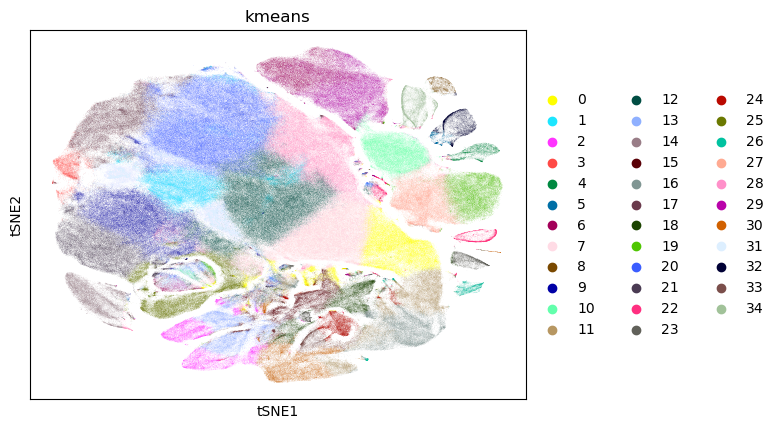

CPU times: user 3.52 s, sys: 240 ms, total: 3.76 s
Wall time: 3.56 s


In [21]:
%%time
sc.pl.tsne(adata, color=["kmeans"])

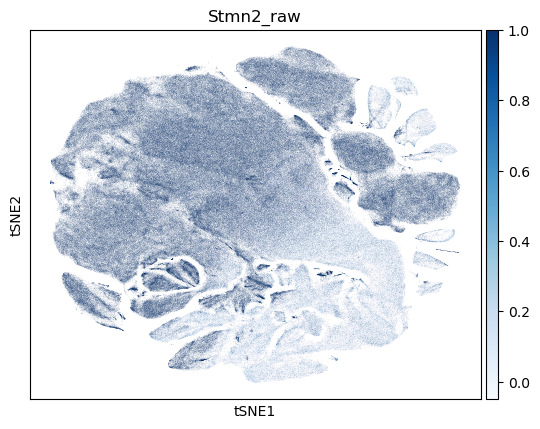

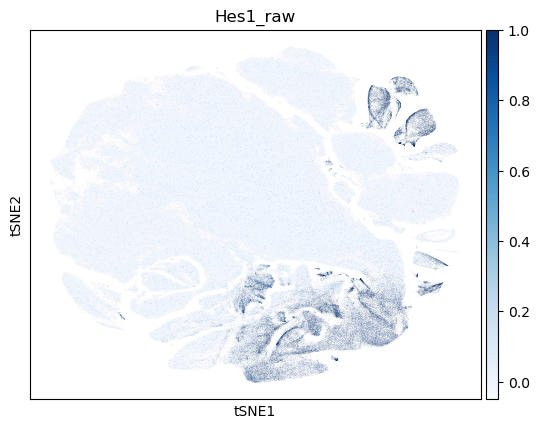

CPU times: user 4.51 s, sys: 312 ms, total: 4.83 s
Wall time: 4.43 s


In [22]:
%%time
sc.pl.tsne(adata, color=["Stmn2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.tsne(adata, color=["Hes1_raw"], color_map="Blues", vmax=1, vmin=-0.05)

### UMAP + Graph clustering

In [23]:
%%time
# KNN graph
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs)

CPU times: user 27min 5s, sys: 33min 4s, total: 1h 9s
Wall time: 2min 12s


In [24]:
%%time
# UMAP
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread)

CPU times: user 21h 11min 28s, sys: 6h 20min 15s, total: 1d 3h 31min 44s
Wall time: 20min 11s


In [25]:
%%time
# Louvain clustering
sc.tl.louvain(adata)

CPU times: user 9min 25s, sys: 3.04 s, total: 9min 28s
Wall time: 9min 25s


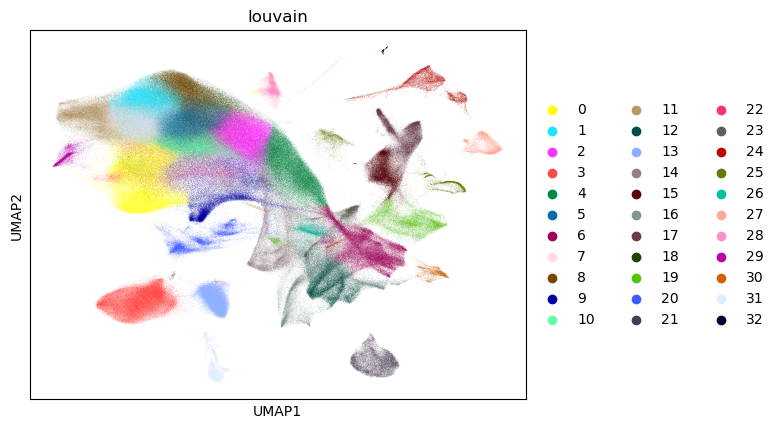

CPU times: user 3.36 s, sys: 160 ms, total: 3.52 s
Wall time: 3.32 s


In [26]:
%%time
sc.pl.umap(adata, color=["louvain"])

In [27]:
%%time
# Leiden clustering
sc.tl.leiden(adata)

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


CPU times: user 34min 6s, sys: 1min 8s, total: 35min 14s
Wall time: 34min 52s


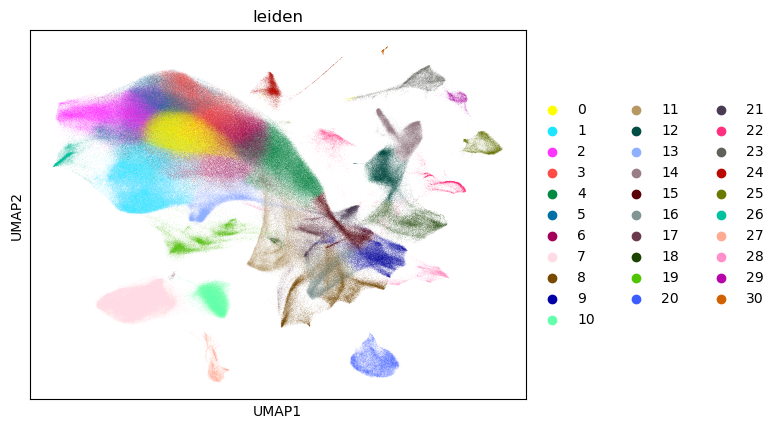

CPU times: user 3.72 s, sys: 177 ms, total: 3.9 s
Wall time: 3.69 s


In [28]:
%%time
sc.pl.umap(adata, color=["leiden"])

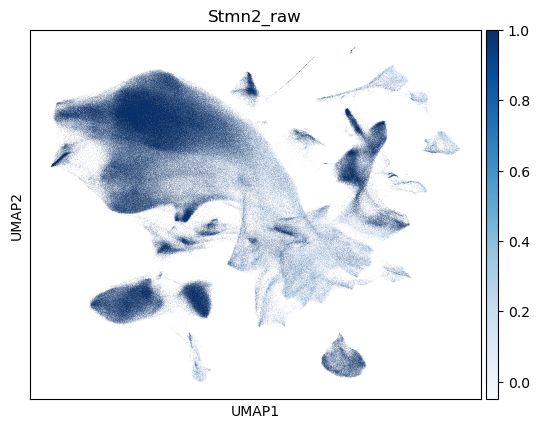

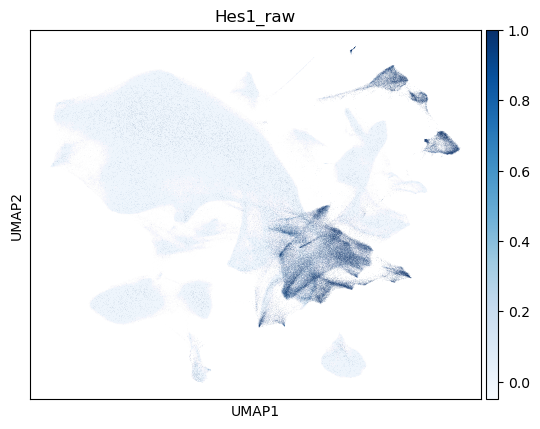

CPU times: user 4.62 s, sys: 296 ms, total: 4.92 s
Wall time: 4.52 s


In [29]:
%%time
sc.pl.umap(adata, color=["Stmn2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, color=["Hes1_raw"], color_map="Blues", vmax=1, vmin=-0.05)

## Differential expression analysis

In [30]:
%%time
sc.tl.rank_genes_groups(adata, groupby="louvain", n_genes=50, groups='all', reference='rest', method='logreg')

CPU times: user 1d 15h 56min 26s, sys: 1d 4h 52min 47s, total: 2d 20h 49min 14s
Wall time: 33min 36s


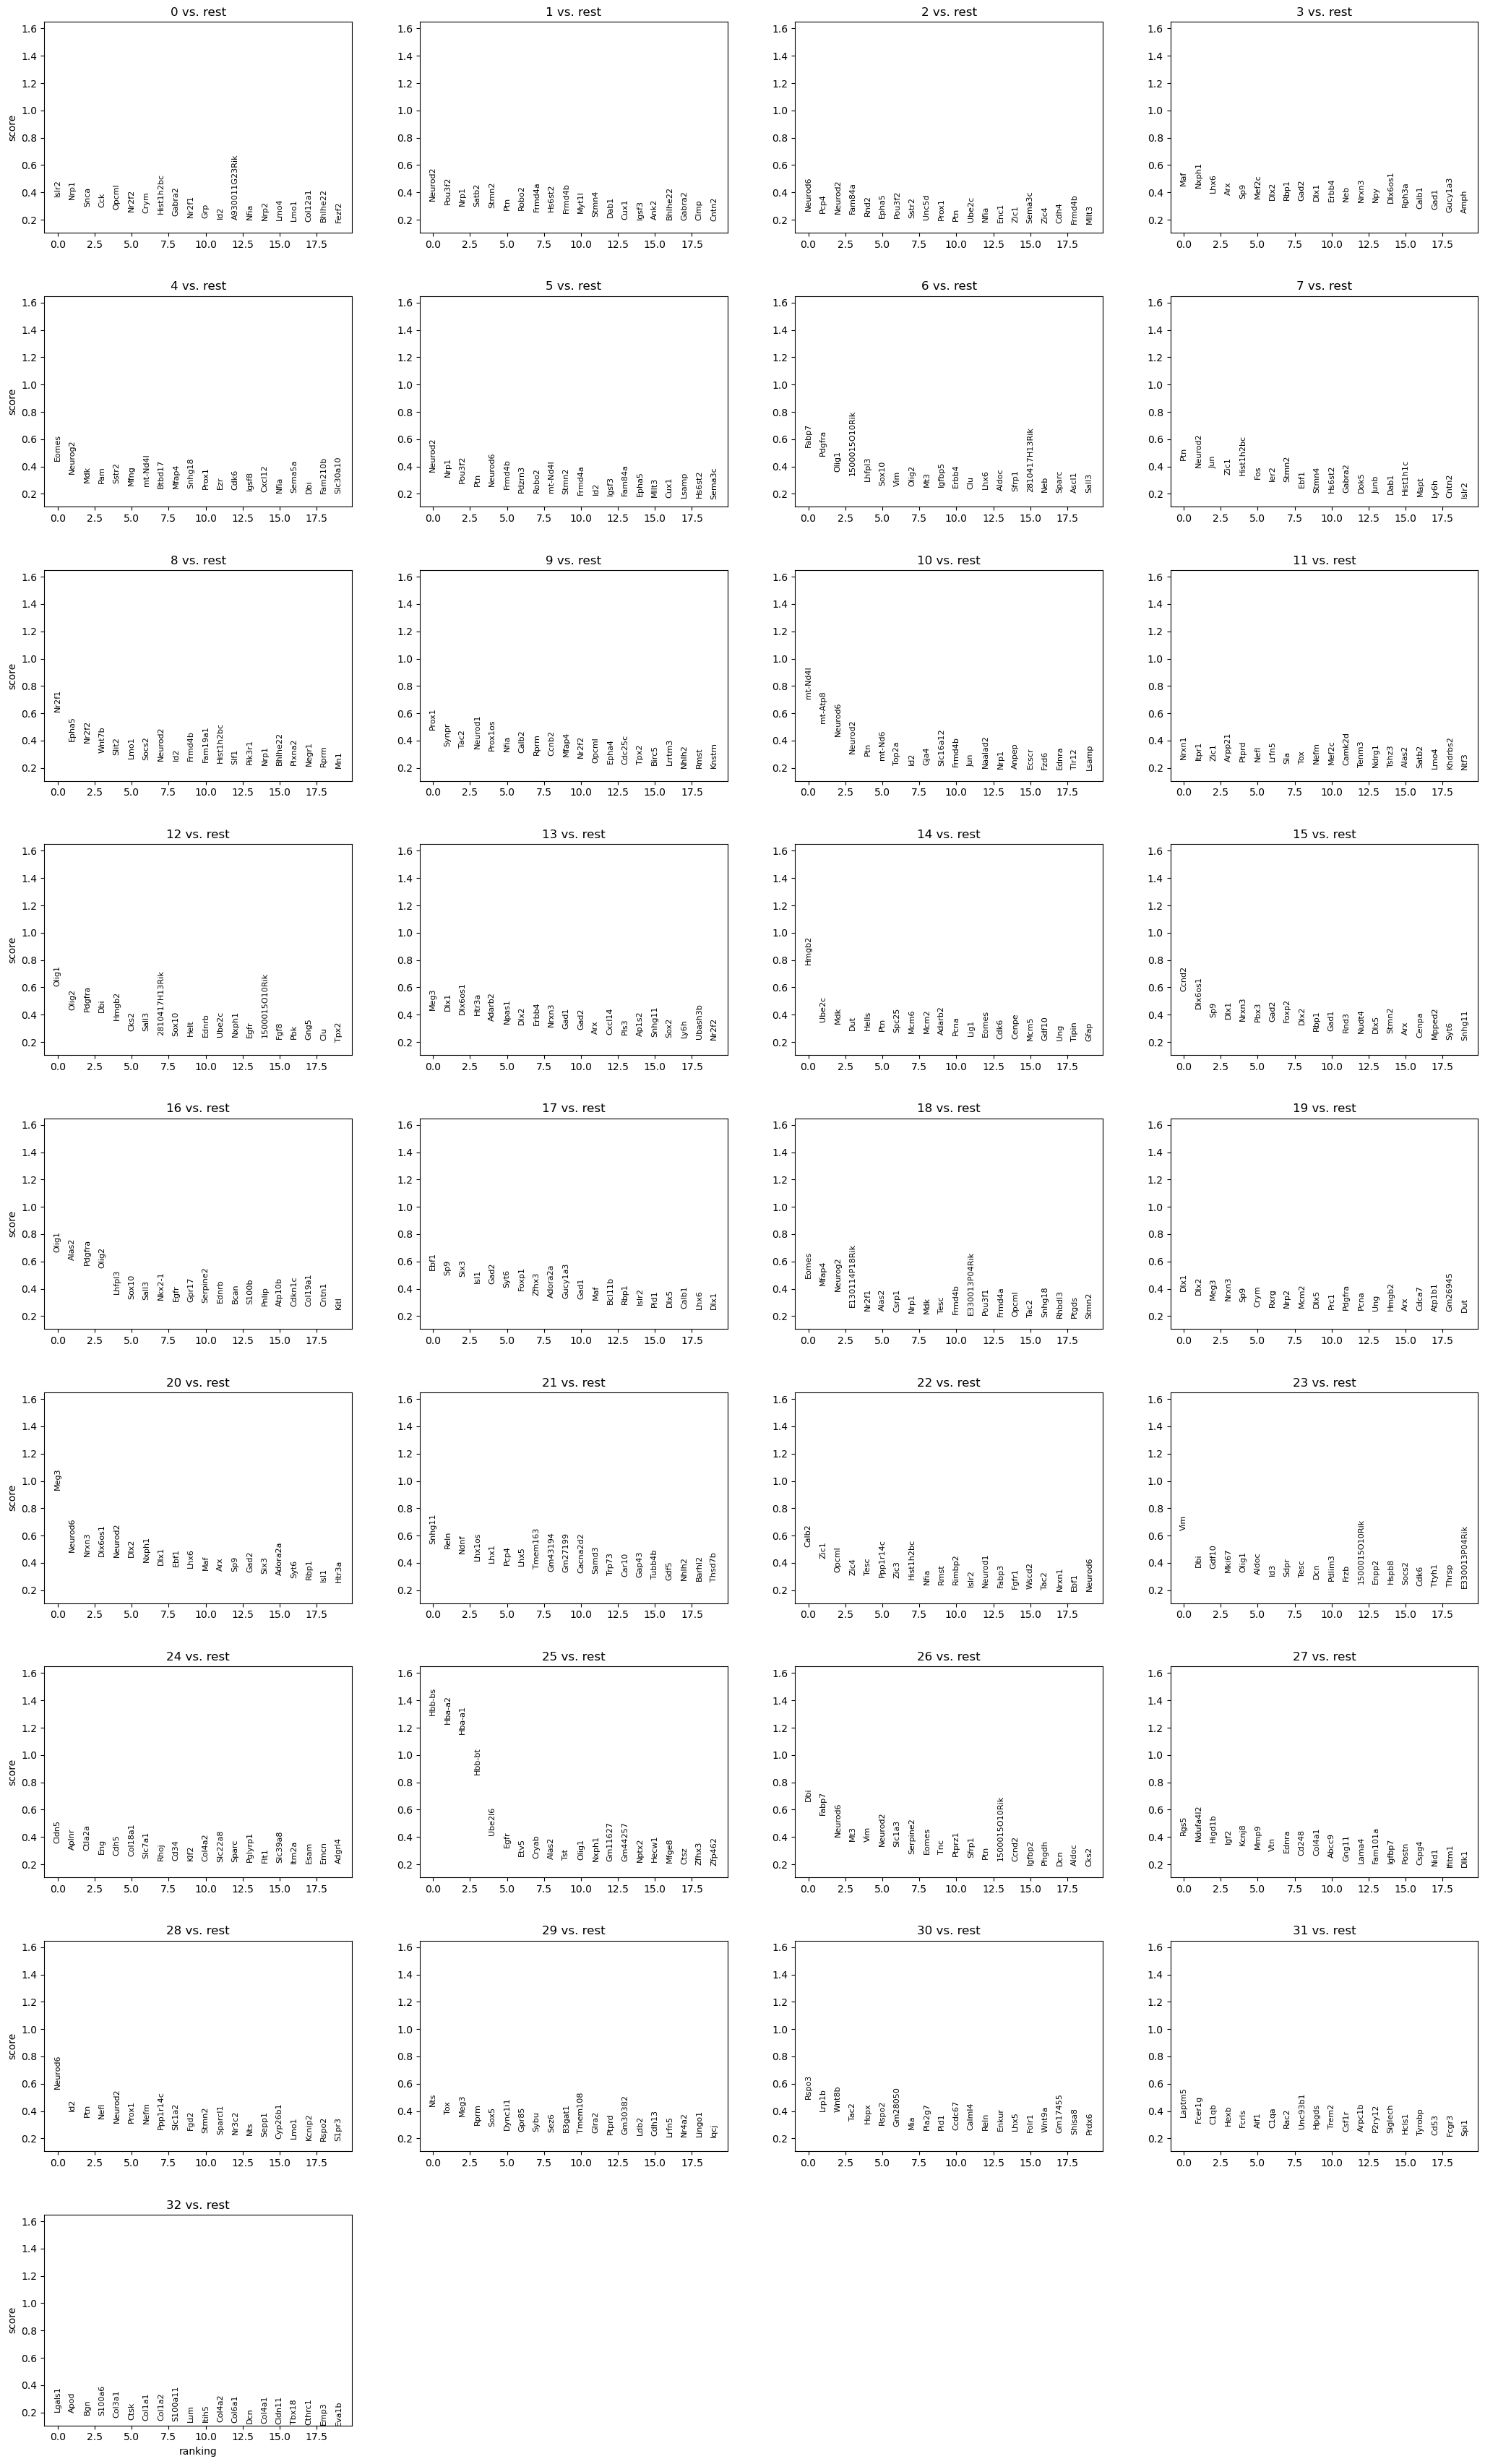

CPU times: user 3.52 s, sys: 977 ms, total: 4.5 s
Wall time: 3.42 s


In [31]:
%%time
sc.pl.rank_genes_groups(adata, n_genes=20)

## Create Zoomed View

The speedup offered by Rapids makes it easy to interactively re-analyze subsets of cells. To illustrate this, we select epithelial cells (EPCAM+) from the dataset.

In [32]:
reanalysis_start = time.time()

In [33]:
%%time
hes1_cells = adata.obs["Hes1_raw"] > 0.0
adata = adata[hes1_cells,:]
adata.shape

CPU times: user 21.3 ms, sys: 586 µs, total: 21.9 ms
Wall time: 21.7 ms


(119794, 4000)

We can repeat the dimension reduction, clustering and visualization using this subset of cells in seconds.

In [34]:
%%time
sc.tl.pca(adata, n_comps=n_components)
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs)
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread)
sc.tl.leiden(adata)

CPU times: user 59min 39s, sys: 18min 28s, total: 1h 18min 7s
Wall time: 1min 47s


And plot the results:

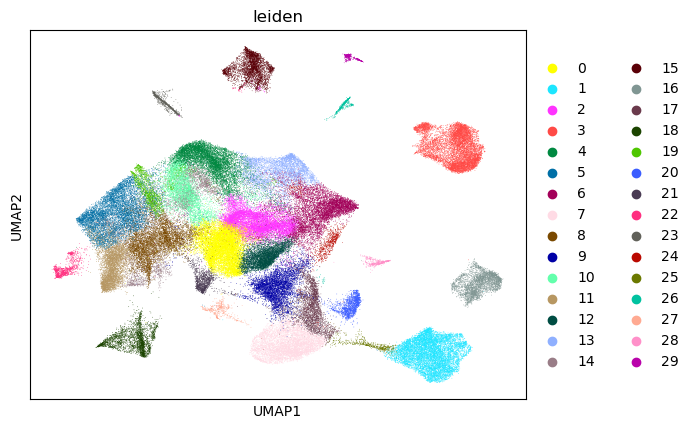

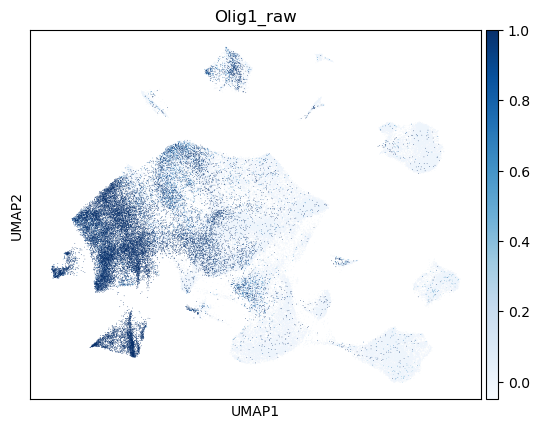

CPU times: user 965 ms, sys: 311 ms, total: 1.28 s
Wall time: 876 ms


In [35]:
%%time
sc.pl.umap(adata, color=["leiden"])
sc.pl.umap(adata, color=["Olig1_raw"], color_map="Blues", vmax=1, vmin=-0.05)

In [36]:
reanalysis_time = time.time()
print("Total reanalysis time : %s" % (reanalysis_time-reanalysis_start))

Total reanalysis time : 108.27110409736633


In [37]:
print("Full time: %s" % (time.time() - start))

Full time: 10037.603346586227
